# Scientific Computing - Applications to Quantum

<div class="questions">

### Questions

- Can Dask be used for embarassingly parallel problems?
- How do you apply it to real functions?

</div>

<div class="objectives">
  
### Objectives

- Learn about dask delayed
- Apply delayed to real problems
- Learn to profile code

</div>


In [2]:
# Import the packages we need
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse
from scipy.sparse import linalg as sla
import time

Define a "computationally intensive" function.

In [4]:
def schrodinger1D(Vfun):
    """
    Solves the 1 dimensional Schrodinger equation numerically
    
    ------ Inputs ------
    Vfun: function, potential energy function
    
    ------- Returns -------
    evl: np.array, eigenvalues
    evt: np.array, eigenvectors
    x: np.array, x axis values
        
    ------- Params to set -------
    xmin: minimum value of the x axis
    xmax: maximum value of the x axis
    Nx: number of finite elements in the x axis
    neigs: number of eigenvalues to find
    """
    
    xmin = -10
    xmax = 10
    Nx = 250
    neigs = 5

    # for this code we are using Dirichlet Boundary Conditions
    x = np.linspace(xmin, xmax, Nx)  # x axis grid
    dx = x[1] - x[0]  # x axis step size
    # Obtain the potential function values:
    V = Vfun(x)
    # create the Hamiltonian Operator matrix:
    H = sparse.eye(Nx, Nx, format = "lil") * 2
    for i in range(Nx - 1):
        H[i, i + 1] = -1
        H[i + 1, i] = -1
        
    H = H / (dx ** 2)
    # Add the potential into the Hamiltonian
    for i in range(Nx):
        H[i, i] = H[i, i] + V[i]
    # convert to csc matrix format
    H = H.tocsc()
    
    # obtain neigs solutions from the sparse matrix
    [evl, evt] = sla.eigs(H, k = neigs, which = "SM")
    for i in range(neigs):
        # normalize the eigen vectors
        evt[:, i] = evt[:, i] / np.sqrt(
                                np.trapz(np.conj(
                                evt[:, i]) * evt[:, i], x))
        # eigen values MUST be real:
        evl = np.real(evl)
    
    return evl, evt, x

Define a function to plot H.

In [5]:
def plot_H(H,neigs=5):
    evl = H[0] # energy eigen values
    indices = np.argsort(evl)

    print("Energy eigenvalues:")
    for i,j in enumerate(evl[indices]):
        print("{}: {:.2f}".format(i + 1, j))

    evt = H[1] # eigen vectors 
    x = H[2] # x dimensions 
    i = 0

    plt.figure(figsize = (4, 2))
    while i < neigs:
        n = indices[i]
        y = np.real(np.conj(evt[:, n]) * evt[:, n])  
        plt.subplot(neigs, 1, i+1)  
        plt.plot(x, y)
        plt.axis('off')
        i = i + 1  
    plt.show()

Define some potenial energy functions we want to explore.

In [7]:
def Vfun1(x, params=[1]):
    '''
    Quantum harmonic oscillator potential energy function
    '''
    V = params[0] * x**2
    return V
    
    
def Vfun2(x, params = 1e10):
    '''
    Infinite well potential energy function
    '''
    V = x * 0
    V[:100]=params
    V[-100:]=params
    return V
   
    
def Vfun3(x, params = [-0.5, 0.01, 7]):
    '''
    Double well potential energy function
    '''
    A = params[0]
    B = params[1]
    C = params[2]
    V = A * x ** 2 + B * x ** 4 + C
    return V

Let's get an idea for how long our schrodinger equation takes to solve.

In [8]:
%%time
H = schrodinger1D(Vfun1)

CPU times: total: 78.1 ms
Wall time: 57.1 ms


Energy eigenvalues:
1: 1.00
2: 3.00
3: 4.99
4: 6.99
5: 8.98


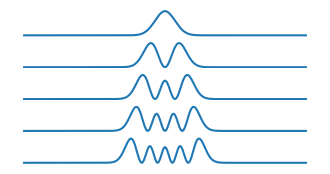

In [9]:
plot_H(H)

In [10]:
%%prun -s cumulative -q -l 10 -T profile.txt
    
H = schrodinger1D(Vfun1)

 
*** Profile printout saved to text file 'profile.txt'.


```
         51234 function calls (51201 primitive calls) in 243.228 seconds

   Ordered by: cumulative time
   List reduced from 214 to 10 due to restriction <10>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000  243.228  243.228 {built-in method builtins.exec}
        1    0.000    0.000  243.228  243.228 <string>:1(<module>)
        1    0.003    0.003  243.227  243.227 3456611332.py:13(schrodinger1D)
        1    0.303    0.303  243.196  243.196 arpack.py:1096(eigs)
      876  240.090    0.274  242.492    0.277 arpack.py:719(iterate)
      875    0.121    0.000    2.402    0.003 _interface.py:201(matvec)
      875    0.107    0.000    2.173    0.002 _interface.py:189(_matvec)
      875    0.205    0.000    2.059    0.002 _interface.py:303(matmat)
      875    0.008    0.000    1.852    0.002 _interface.py:730(_matmat)
      875    0.104    0.000    1.844    0.002 _base.py:400(dot)
 ```
 
Okay. There may not be anything we can improve of greatly. The slowest part is a highly optimised scipy subroutine that is calling fortran under-the-hood! So what if we wanted to run this function 2 times, 3 times, a million times? Perhaps trying different configuration parameters, or specifically here, different potential energy functions.

In [11]:
#The slow way: Loop through each of the PE definitions 
# and run the function one at a time.
H = []
for f in [Vfun1,Vfun2,Vfun3] :
    tic = time.time()
    result = schrodinger1D(f)
    print(time.time() - tic, "s for", f)
    H.append(result)

0.022294044494628906 s for <function Vfun1 at 0x000001A97F662DC0>
0.02023482322692871 s for <function Vfun2 at 0x000001A97F662E50>
0.053911447525024414 s for <function Vfun3 at 0x000001A97F662EE0>


In [12]:
#The DASK embarassingly parallel way!
import dask

In [13]:
%%time
lazy_H = []
for f in [Vfun1,Vfun2,Vfun3]:
    H_temp = dask.delayed(schrodinger1D)(f)
    lazy_H.append(H_temp)

CPU times: total: 0 ns
Wall time: 0 ns


In [14]:
lazy_H

[Delayed('schrodinger1D-e209d7d7-5784-410f-acd1-829458ab1f8e'),
 Delayed('schrodinger1D-689fef4f-21d2-4dba-8439-7f281693bc21'),
 Delayed('schrodinger1D-db753a7f-4fb2-4ce2-b902-1edfc8aac473')]

In [15]:
%%time 

HH = dask.compute(*lazy_H)

CPU times: total: 156 ms
Wall time: 147 ms


<div class="challenge">

### Challenge 

Can you write you change some of the parameters in the schrodinger1D function and see how the timing changes?

Can you write your own PE function and add it to the dask delayed lazy compute list?
    
<details>
<summary>Solution</summary>

Try changing the Nx parameter.
```python
Nx = 250
```

</details>
</div>

<div class="keypoints">

### Key points

- Dask can be used for embarassingly parallel problems.
- Finding where to make your code faster and understanding what kind of code/data you can determine which approaches you use.


</div>
